Training models...
Trained GMM for speaker1
Trained GMM for speaker2
Trained GMM for speaker3
Trained GMM for speaker4

Testing speaker predictions...

Confusion Matrix:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]

Accuracy: 100.00%
Error Rate: 0.00%


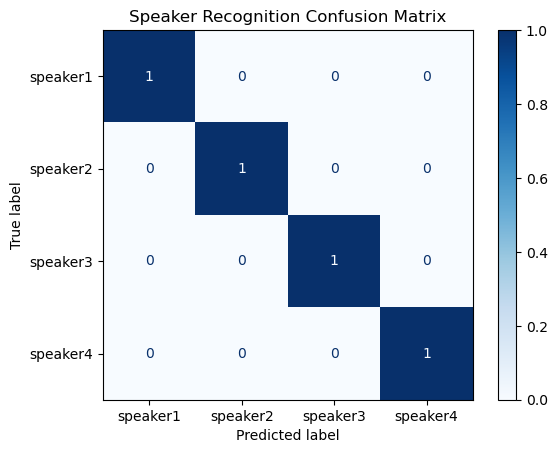


Probe Results:

 probe_2.wav Scores:
  ➤ Score vs speaker1: -82.79
  ➤ Score vs speaker2: -51.36
  ➤ Score vs speaker3: -76.08
  ➤ Score vs speaker4: -51.64


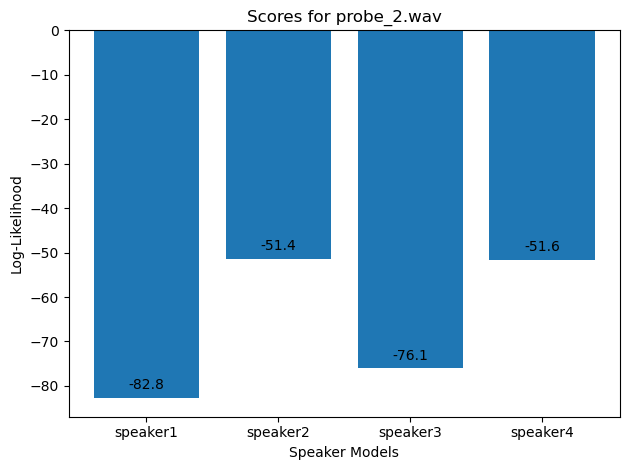


 probe_1.wav Scores:
  ➤ Score vs speaker1: -52.35
  ➤ Score vs speaker2: -90.88
  ➤ Score vs speaker3: -52.06
  ➤ Score vs speaker4: -88.34


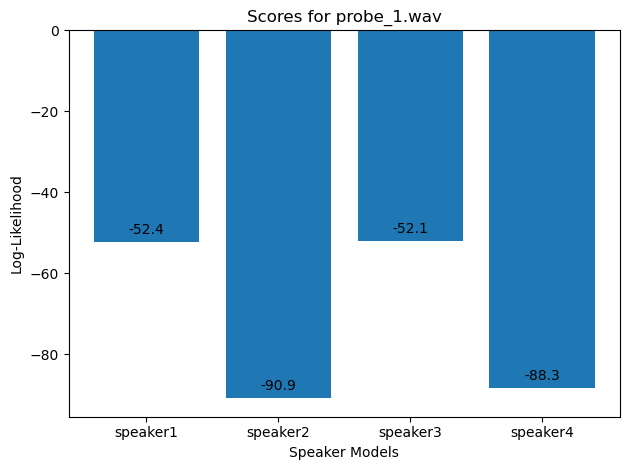

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from python_speech_features import mfcc

# Parameters
n_components = 10
n_mfcc = 13
base_path = '../wav-files'  
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
probe_path = os.path.join(base_path, 'probe')

# Step 1: Get speaker list based on filename prefixes
train_files = os.listdir(train_path)
speakers = sorted(set(f.split('_')[0] for f in train_files))

# Step 2: Feature Extraction
def extract_features(filepath):
    sr, signal = wavfile.read(filepath)
    return mfcc(signal, samplerate=sr, numcep=n_mfcc, nfft=2048)

# Step 3: Train GMM Models
speaker_models = {}
print("Training models...")
for speaker in speakers:
    speaker_train_files = [f for f in train_files if f.startswith(speaker)]
    all_features = []
    for filename in speaker_train_files:
        path = os.path.join(train_path, filename)
        feats = extract_features(path)
        all_features.append(feats)
    combined = np.vstack(all_features)
    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=200)
    gmm.fit(combined)
    speaker_models[speaker] = gmm
    print(f"Trained GMM for {speaker}")

# Step 4: Testing and Confusion Matrix
print("\nTesting speaker predictions...")
test_files = os.listdir(test_path)
true_labels = []
pred_labels = []

for test_file in test_files:
    path = os.path.join(test_path, test_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    predicted_index = np.argmax(scores)
    predicted_speaker = list(speaker_models.keys())[predicted_index]
    
    true_speaker = test_file.split('_')[0]
    true_labels.append(true_speaker)
    pred_labels.append(predicted_speaker)

# Create and display confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=speakers)
accuracy = np.trace(cm) / np.sum(cm)
error_rate = 1 - accuracy

print("\nConfusion Matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=speakers)
disp.plot(cmap='Blues')
plt.title("Speaker Recognition Confusion Matrix")
plt.show()

# Step 5: Probe Validation
print("\nProbe Results:")
probe_files = os.listdir(probe_path)

for probe_file in probe_files:
    path = os.path.join(probe_path, probe_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    
    print(f"\n {probe_file} Scores:")
    for speaker, score in zip(speaker_models.keys(), scores):
        print(f"  ➤ Score vs {speaker}: {score:.2f}")

    # Bar plot with score labels
    plt.figure()
    bars = plt.bar(speaker_models.keys(), scores)
    plt.title(f"Scores for {probe_file}")
    plt.ylabel("Log-Likelihood")
    plt.xlabel("Speaker Models")

    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, score + 2, f"{score:.1f}", ha='center')

    plt.tight_layout()
    plt.show()

In [25]:
# Step 6: Threshold & Summary Enhancements 
SCORE_THRESHOLD = -50.0  
#All test scores are above -50.0
#All probe scores are below -50.0

# Track false accepts and true rejections from probe validation
false_accepts = 0
true_rejects = 0

print("\nThreshold-based Evaluation of Probe Results:")
for probe_file in probe_files:
    path = os.path.join(probe_path, probe_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    max_score = max(scores)
    best_match = list(speaker_models.keys())[np.argmax(scores)]

    if max_score >= SCORE_THRESHOLD:
        print(f" {probe_file} was incorrectly accepted as {best_match} (score: {max_score:.2f})")
        false_accepts += 1
    else:
        print(f" {probe_file} was correctly rejected (score: {max_score:.2f})")
        true_rejects += 1

# Final probe summary
print("\nProbe Summary with Threshold:")
print(f"True Rejections: {true_rejects}")
print(f"False Acceptances: {false_accepts}")

# Optional: Summary of test predictions
print("\nTest Prediction Summary:")
for true, pred in zip(true_labels, pred_labels):
    status = "Correct" if true == pred else "Incorrect"
    print(f"{true} → {pred} ({status})")



Threshold-based Evaluation of Probe Results:
 probe_2.wav was correctly rejected (score: -51.36)
 probe_1.wav was correctly rejected (score: -52.06)

Probe Summary with Threshold:
True Rejections: 2
False Acceptances: 0

Test Prediction Summary:
speaker3 → speaker3 (Correct)
speaker2 → speaker2 (Correct)
speaker4 → speaker4 (Correct)
speaker1 → speaker1 (Correct)



Max Scores for Test (Known) Samples:
speaker3_test.wav: Max Score = -49.14 | Predicted = speaker3 | True = speaker3
speaker2_test.wav: Max Score = -47.40 | Predicted = speaker2 | True = speaker2
speaker4_test.wav: Max Score = -48.79 | Predicted = speaker4 | True = speaker4
speaker1_test.wav: Max Score = -47.21 | Predicted = speaker1 | True = speaker1


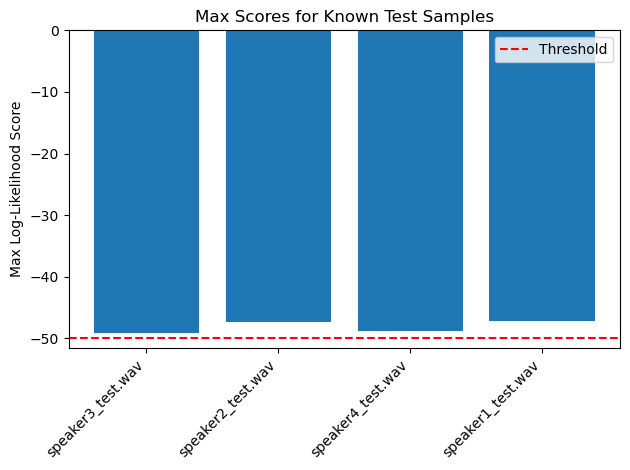

In [26]:
# Step 7: Analyze max scores for test (known) samples
print("\nMax Scores for Test (Known) Samples:")

test_scores = []
for test_file in test_files:
    path = os.path.join(test_path, test_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    max_score = max(scores)
    test_scores.append(max_score)
    
    predicted_speaker = list(speaker_models.keys())[np.argmax(scores)]
    true_speaker = test_file.split('_')[0]

    print(f"{test_file}: Max Score = {max_score:.2f} | Predicted = {predicted_speaker} | True = {true_speaker}")

# Visualize test scores
plt.figure()
plt.bar(range(len(test_scores)), test_scores)
plt.axhline(SCORE_THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.xticks(range(len(test_scores)), test_files, rotation=45, ha='right')
plt.ylabel("Max Log-Likelihood Score")
plt.title("Max Scores for Known Test Samples")
plt.legend()
plt.tight_layout()
plt.show()
